<a href="https://colab.research.google.com/github/Ignas12345/Project_in_computational_biology_take_2/blob/main/notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/Nikronic/EdgeNet.git
!git clone https://github.com/Ignas12345/Project_in_Computational_Biology_take_2.git

Cloning into 'EdgeNet'...
remote: Enumerating objects: 127, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 127 (delta 2), reused 4 (delta 1), pack-reused 121
Receiving objects: 100% (127/127), 808.96 KiB | 15.26 MiB/s, done.
Resolving deltas: 100% (72/72), done.
Cloning into 'Project_in_Computational_Biology_take_2'...
remote: Enumerating objects: 173, done.
remote: Counting objects: 100% (173/173), done.
remote: Compressing objects: 100% (170/170), done.
remote: Total 173 (delta 50), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (173/173), 19.49 MiB | 9.73 MiB/s, done.
Resolving deltas: 100% (50/50), done.


Import libraries and choose your processor

In [ ]:
from Project_in_Computational_Biology_take_2.code.skip import skip
from Project_in_Computational_Biology_take_2.code.downsampler import Downsampler
from Project_in_Computational_Biology_take_2.code.helpers import *
from Project_in_Computational_Biology_take_2.code.CV_methods import *
from EdgeNet.EdgeNet import EdgeNet

import os

In [ ]:
os.makedirs('DIP_images')
os.makedirs('Files_to_download') #This folder will store images of the edge map(/-s)
os.makedirs('Images_with_edge_regularization')

In [ ]:
#choose CPU or GPU

processor = 'GPU'

if processor == 'GPU':
  torch.backends.cudnn.enabled = True
  torch.backends.cudnn.benchmark =True
  dtype = torch.cuda.FloatTensor

if processor == 'CPU':
  dtype = torch.FloatTensor

set up the parameters

In [ ]:
orig_img = Image.open('/content/9.png')

In [ ]:
num_input_channels = 1
num_output_channels = 1
upscaling_factor = 4
n_iterations = 4000
downsampler = None

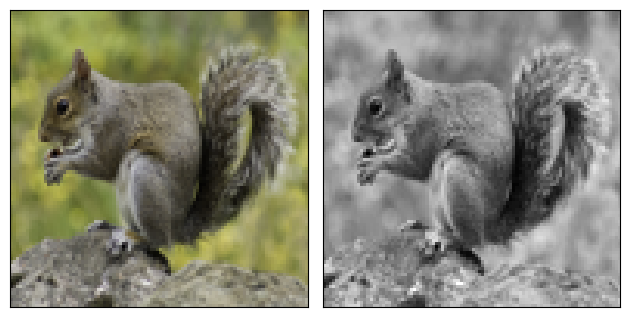

In [ ]:
grayscale_img = turn_to_grayscale(orig_img)
plot([orig_img, grayscale_img], cmap = 'gray')

In [ ]:
grayscale_img.save('/content/Files_to_download/corrupted_img.jpg')

set up model and input

In [ ]:
dip_model = skip(num_input_channels = num_input_channels, num_output_channels = num_output_channels, need_bias = True, upsample_mode = 'bilinear').type(dtype)

In [ ]:
noise_img = generate_noise(grayscale_img, upscaling_factor = upscaling_factor)
target_img = grayscale_img

In [ ]:
noise_tensor = image_to_tensor(noise_img)
noise_img = tensor_to_image(noise_tensor) #this line gets the image of noise into the required format for using with the neural network

define optimization loop and train

In [ ]:
downsampler = Downsampler(n_planes = 1, factor = upscaling_factor, kernel_type= 'lanczos3', preserve_size=True).type(dtype) #this line is optional. It allows to specify the type of downsampling kernel to be used.

In [ ]:
optimize_upscaling(dip_model, noise_img, target_img, n_iterations, upscaling_factor = upscaling_factor, dtype = dtype, downsampler = downsampler)

Get the edge map and retrain using it.

In [ ]:
edgenet = EdgeNet(input_channels = 1).type(dtype)
edgenet.load_state_dict(torch.load('Project_in_Computational_Biology_take_2/model_parameters/EdgeNet_parameters/model_parameters_5'))

<All keys matched successfully>

In [ ]:
input_for_edges_img = Image.open('/content/DIP_images/High_resolution_iteration_200.jpg')

In [ ]:
edge_map_tensor = get_edges_with_edgenet(input_for_edges_img, edgenet, save_img = True, dtype = dtype)
#maybe you can apply CV methods to the edge_map that you get?

In [ ]:
overfitted_img = Image.open('/content/DIP_images/High_resolution_iteration_4000.jpg')
overfitted_edges_tensor = get_edges_with_edgenet(overfitted_img, edgenet, save_img = True, dtype = dtype)

In [ ]:
edges_mse = torch.mean(torch.square(edge_map_tensor - overfitted_edges_tensor))
print('typical mse for edges: ' + str(edges_mse))

typical mse for edges: tensor(0.0230, device='cuda:0')


Lastly, run optimization with edge_maps

In [ ]:
dip_model = skip(num_input_channels = num_input_channels, num_output_channels = num_output_channels, need_bias = True, upsample_mode = 'bilinear').type(dtype)

In [ ]:
optimize_with_edges(dip_model, input_img = noise_img, target_img = grayscale_img, edge_map_tensor= edge_map_tensor, edgenet_model= edgenet, n_iterations= 2* n_iterations, upscaling_factor= upscaling_factor, edge_weight = 0.125, dtype = dtype, downsampler = downsampler, lr = 0.001)

In [ ]:
torch.save(dip_model.state_dict(), '/content/Files_to_download/dip_with_edges_parameters')